In [2]:
import numpy as np
from skimage import io, filters

# 1. Load the image
# Replace 'your_image.tif' with the actual path to your file
image_path = 'Result of Result of SUM_CL586_1.nd2 - CL586_1.nd2 (series 01) - C=0.tif'

try:
    # We load as a raw array. If your image is RGB, add as_gray=True
    original_image = io.imread(image_path)
    print(f"Image loaded successfully. Shape: {original_image.shape}")

    # 2. Apply Gaussian blur to reduce noise
    # sigma controls the amount of blur. 1.0 is standard for mild denoising.
    blurred_image = filters.gaussian(original_image, sigma=1.0, preserve_range=True)

    # 3. Apply Otsu threshold to create a mask
    # Calculate the optimal threshold value
    threshold_value = filters.threshold_otsu(blurred_image)

    # Create the binary mask (Boolean array: True for cells, False for background)
    mask = blurred_image > threshold_value

    # 4. Measure Total Integrated Density
    # CRITICAL: We use the mask from the *blurred* image,
    # but we sum the pixels from the *original* image to preserve photometric accuracy.

    # logical indexing selects only pixels where mask is True
    pixels_inside_cells = original_image[mask]
    integrated_density = np.sum(pixels_inside_cells)

    # 5. Print the result
    print("-" * 30)
    print(f"Otsu Threshold Value: {threshold_value:.2f}")
    print(f"Total Integrated Density: {integrated_density:.2f}")
    print("-" * 30)

except FileNotFoundError:
    print(f"Error: The file '{image_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Image loaded successfully. Shape: (512, 512)
------------------------------
Otsu Threshold Value: 699.56
Total Integrated Density: 48574432.00
------------------------------


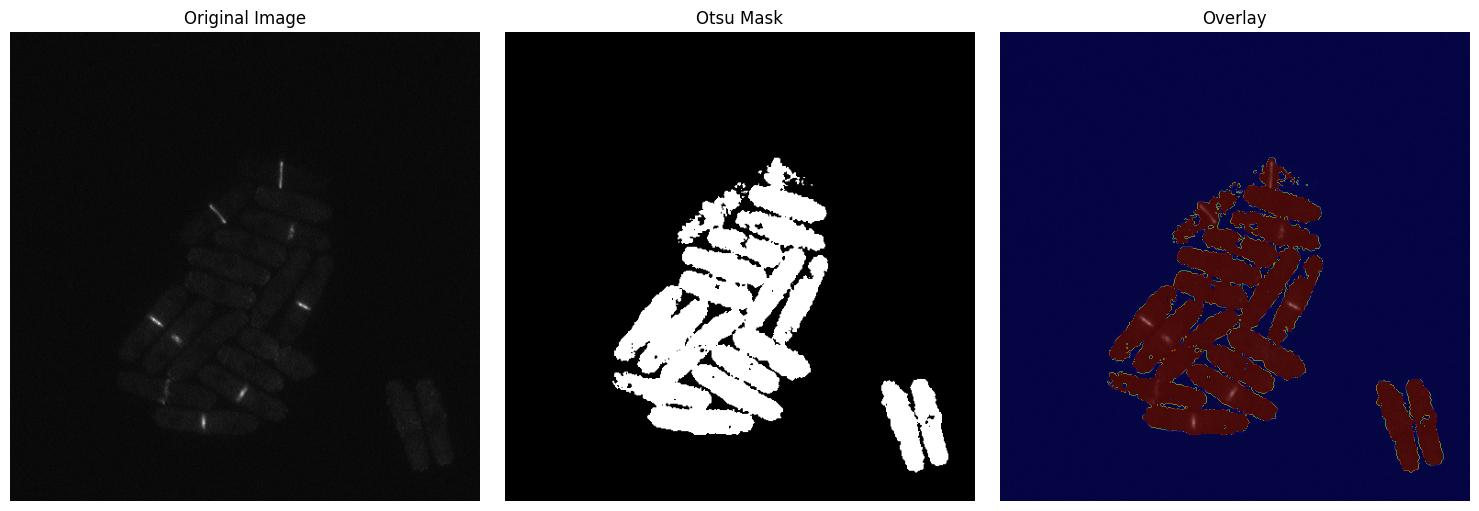

In [3]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax = axes.ravel()

ax[0].imshow(original_image, cmap='gray')
ax[0].set_title('Original Image')

ax[1].imshow(mask, cmap='gray')
ax[1].set_title('Otsu Mask')

# Overlay mask on image
ax[2].imshow(original_image, cmap='gray')
ax[2].imshow(mask, cmap='jet', alpha=0.5) # alpha sets transparency
ax[2].set_title('Overlay')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

In [11]:
import zipfile

zip_file_path = 'CMMTP_example_images.zip' # Using the already defined variable

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        print(f"Contents of '{zip_file_path}':")
        for item in zip_ref.namelist():
            # Skip __MACOSX folders and macOS metadata files
            if '__MACOSX' not in item:
                print(item)
except FileNotFoundError:
    print(f"Error: The file '{zip_file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Contents of 'CMMTP_example_images.zip':
CMMTP_example_images/
CMMTP_example_images/Test cells (deltaImp2 mEGFP-Cdc15)/
CMMTP_example_images/.DS_Store
CMMTP_example_images/Control cells (mEGFP-Cdc15)/
CMMTP_example_images/Test cells (deltaImp2 mEGFP-Cdc15)/Result of Result of SUM_CL914_1001.nd2 - CL914_1001.nd2 (series 03) - C=0.tif
CMMTP_example_images/Test cells (deltaImp2 mEGFP-Cdc15)/Result of Result of SUM_CL914_1.nd2 - CL914_1.nd2 (series 19) - C=0.tif
CMMTP_example_images/Test cells (deltaImp2 mEGFP-Cdc15)/Result of Result of SUM_CL914_1001.nd2 - CL914_1001.nd2 (series 28) - C=0.tif
CMMTP_example_images/Test cells (deltaImp2 mEGFP-Cdc15)/Result of Result of SUM_CL914_1.nd2 - CL914_1.nd2 (series 05) - C=0.tif
CMMTP_example_images/Test cells (deltaImp2 mEGFP-Cdc15)/Result of Result of SUM_CL914_1.nd2 - CL914_1.nd2 (series 23) - C=0.tif
CMMTP_example_images/Test cells (deltaImp2 mEGFP-Cdc15)/Result of Result of SUM_CL914_1.nd2 - CL914_1.nd2 (series 14) - C=0.tif
CMMTP_example_images

In [14]:
import os
import zipfile
import numpy as np
import pandas as pd
from skimage import io, filters

def process_batch_images(zip_file_path, extract_path='extracted_images'):
    """
    Unzips a file, recursively searches for .tif images, and measures integrated density.
    """

    # 1. Unzip the file
    if not os.path.exists(zip_file_path):
        print(f"Error: The file '{zip_file_path}' was not found.")
        return

    print(f"Unzipping {zip_file_path} to '{extract_path}'...")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    # List to collect data for each image
    data_records = []

    # 2. Walk through the directory tree
    # os.walk automatically handles multiple subfolders (nested directories)
    print("Processing images...")
    for root, dirs, files in os.walk(extract_path):
        # Skip __MACOSX folders
        if '__MACOSX' in root:
            continue
        for filename in files:
            # Skip macOS metadata files (files starting with ._)
            if filename.startswith('._'):
                continue
            # Check for tif extension (case-insensitive)
            if filename.lower().endswith(('.tif', '.tiff')):
                file_path = os.path.join(root, filename)

                try:
                    # --- Image Analysis Pipeline ---

                    # Load image
                    image = io.imread(file_path)

                    # Apply Gaussian blur
                    blurred = filters.gaussian(image, sigma=1.0, preserve_range=True)

                    # Apply Otsu threshold
                    threshold_val = filters.threshold_otsu(blurred)
                    mask = blurred > threshold_val

                    # Measure Integrated Density
                    # Sum of intensity of ORIGINAL pixels where mask is True
                    integrated_density = np.sum(image[mask])

                    # --- Record Results ---
                    data_records.append({
                        'Folder': os.path.basename(root),
                        'Filename': filename,
                        'Threshold': threshold_val,
                        'Integrated Density': integrated_density
                    })

                except Exception as e:
                    print(f"Could not process {filename}: {e}")

    # 3. Output the results
    if data_records:
        df = pd.DataFrame(data_records)

        # Print summary to console
        print("\n" + "="*40)
        print("BATCH ANALYSIS COMPLETE")
        print("="*40)
        print(df)

        # Save to CSV
        output_csv = 'cell_analysis_results.csv'
        df.to_csv(output_csv, index=False)
        print(f"\nResults saved to '{output_csv}'")
    else:
        print("No .tif images were found in the extracted folders.")

# --- Main Execution ---
# Define the path you provided
zip_location = 'CMMTP_example_images.zip'

# Run the function
process_batch_images(zip_location)

Unzipping CMMTP_example_images.zip to 'extracted_images'...
Processing images...

BATCH ANALYSIS COMPLETE
                                Folder  \
0   Test cells (deltaImp2 mEGFP-Cdc15)   
1   Test cells (deltaImp2 mEGFP-Cdc15)   
2   Test cells (deltaImp2 mEGFP-Cdc15)   
3   Test cells (deltaImp2 mEGFP-Cdc15)   
4   Test cells (deltaImp2 mEGFP-Cdc15)   
..                                 ...   
90         Control cells (mEGFP-Cdc15)   
91         Control cells (mEGFP-Cdc15)   
92         Control cells (mEGFP-Cdc15)   
93         Control cells (mEGFP-Cdc15)   
94         Control cells (mEGFP-Cdc15)   

                                             Filename    Threshold  \
0   Result of Result of SUM_CL914_1001.nd2 - CL914...  2396.497803   
1   Result of Result of SUM_CL914_1.nd2 - CL914_1....  2776.047852   
2   Result of Result of SUM_CL914_1001.nd2 - CL914...   653.142639   
3   Result of Result of SUM_CL914_1.nd2 - CL914_1....  1505.086792   
4   Result of Result of SUM_CL914_1.nd2

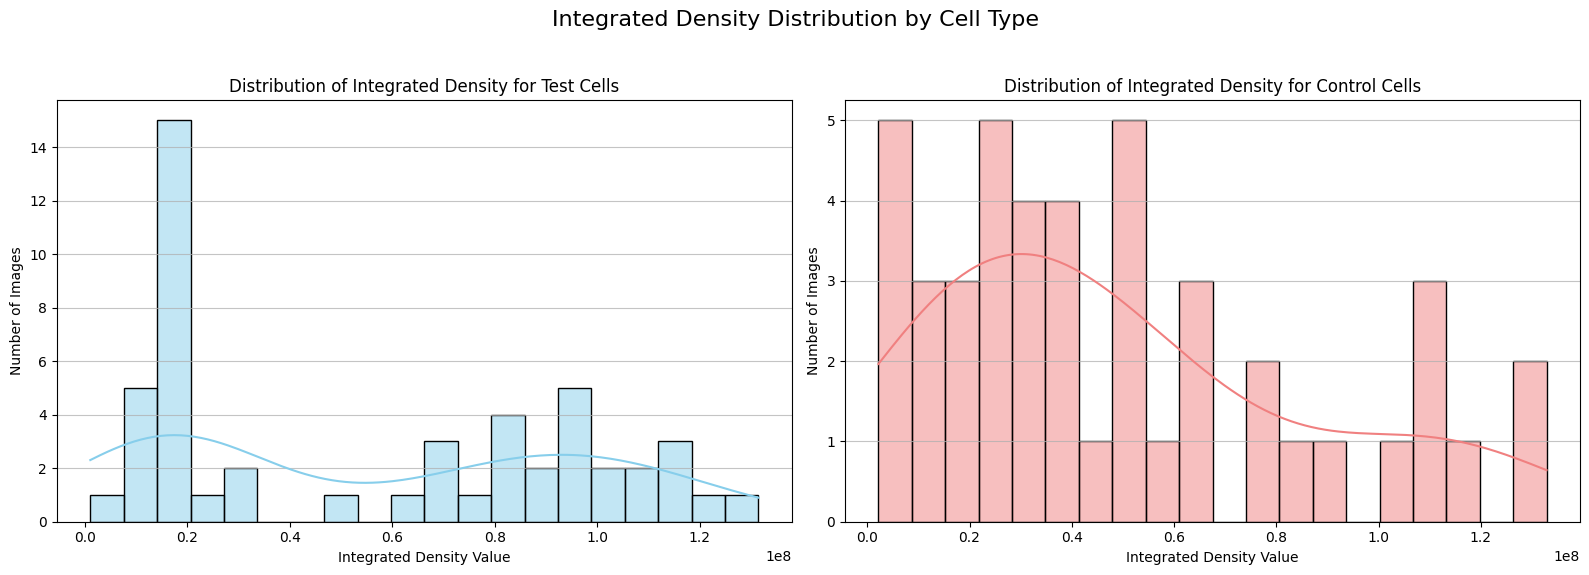

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the results from the CSV file
df = pd.read_csv('cell_analysis_results.csv')

# Separate data into two groups
df_test_cells = df[df['Folder'] == 'Test cells (deltaImp2 mEGFP-Cdc15)']
df_control_cells = df[df['Folder'] == 'Control cells (mEGFP-Cdc15)']

# Create a two-pane figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for Test cells
sns.histplot(data=df_test_cells, x='Integrated Density', bins=20, kde=True, color='skyblue', edgecolor='black', ax=axes[0])
axes[0].set_title('Distribution of Integrated Density for Test Cells')
axes[0].set_xlabel('Integrated Density Value')
axes[0].set_ylabel('Number of Images')
axes[0].grid(axis='y', alpha=0.75)

# Plot for Control cells
sns.histplot(data=df_control_cells, x='Integrated Density', bins=20, kde=True, color='lightcoral', edgecolor='black', ax=axes[1])
axes[1].set_title('Distribution of Integrated Density for Control Cells')
axes[1].set_xlabel('Integrated Density Value')
axes[1].set_ylabel('Number of Images')
axes[1].grid(axis='y', alpha=0.75)

plt.suptitle('Integrated Density Distribution by Cell Type', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

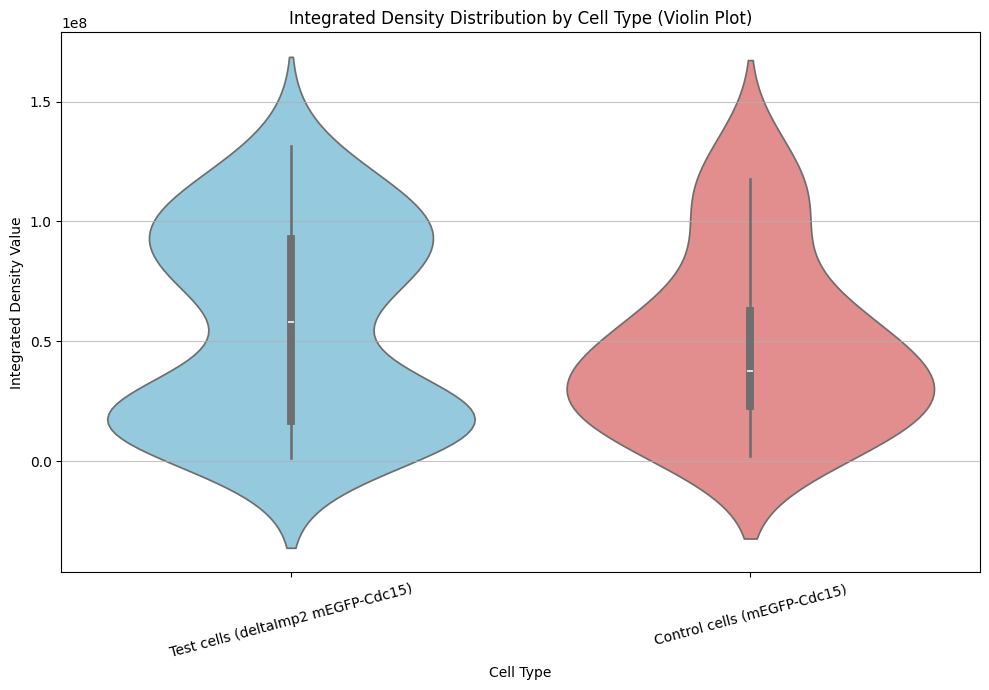

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the results from the CSV file (assuming it's already generated and available)
df = pd.read_csv('cell_analysis_results.csv')

plt.figure(figsize=(10, 7))
sns.violinplot(data=df, x='Folder', y='Integrated Density', hue='Folder', legend=False, palette={'Test cells (deltaImp2 mEGFP-Cdc15)': 'skyblue', 'Control cells (mEGFP-Cdc15)': 'lightcoral'})
plt.title('Integrated Density Distribution by Cell Type (Violin Plot)')
plt.xlabel('Cell Type')
plt.ylabel('Integrated Density Value')
plt.xticks(rotation=15) # Rotate x-axis labels if they are long
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()